## Setting

In [1]:
import os

if not os.path.exists("../small_libs"):
    print("the directory small_libs is created")
    !git clone https://github.com/vincentvigon/small_libs
    %cd small_libs
else:
    print("the directory small_libs is updated")
    %cd small_libs
    !git pull https://github.com/vincentvigon/small_libs

the directory small_libs is created
Cloning into 'small_libs'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 96 (delta 20), reused 93 (delta 17), pack-reused 0
Unpacking objects: 100% (96/96), done.
/content/small_libs


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/Othercomputers/Mon MacBook Pro/google_saved/PYTHON/small_libs
# %ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%reload_ext autoreload
%autoreload 2

In [3]:
%pwd
%ls

sample_data/  small_libs/


In [6]:
import small_libs.fourier_neural_operator.FNO_1d_plus as fno
#import fourier_neural_operator.test_env as te
import small_libs.grid_up.grid_up as gr

In [11]:
pp=print
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import inspect

In [2]:
from fourier_neural_operator.test_newton.generate_data_tf import *

# Apprentissage classique

## Création des données

In [6]:
def give_me_newtonData(N):
    return NewtonData(a=0,b=1,N=N,k=lambda u: u ** 4 + 1.0,kind="gauss",BC="dirichlet")

In [7]:
data_creator_train=give_me_newtonData(200)

NewtonData with: nb points=200, kind of data:gauss


In [8]:
X,Y=data_creator_train.make_XY(batch_size=10)

traçage de la fonction generate_XY


* Les 2 channels de `X` correspondent à $f,\alpha$.
* Le channel de `Y` correspond à $U$

In [9]:
X.shape, Y.shape

(TensorShape([10, 200, 2]), TensorShape([10, 200, 1]))

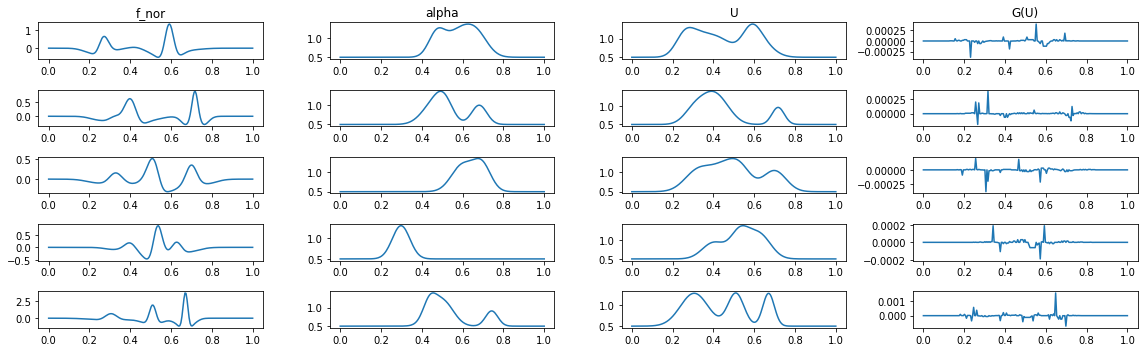

In [10]:
data_creator_train.plot_data(X,Y)

Notons qu'en 32 bit, les résidus on des pointent à 5e-4

## Définition du modèle

In [31]:
def foo(a, b, x='blah'):
    pass



print_signature(foo)  

a, b, x='blah'
a
b
x='blah'


Voici la signature du modèle


In [14]:
print(inspect.signature(fno.FNO1d_plus.__init__))

(self, modes: int, width: int, out_channels: int, nb_layer=4, first_channel_unchanged=False, freq_mix_size=0, pad_prop=0.1, pad_kind='zero_padding', verbose=False)




* mode: nombre de coefficients de fourier gardés
* width: dimension de travail des layers
* out_channels: dimension de sortie
* nb_layer=4: le nombre de layers
* first_channel_unchanged=True Si l'on veut garder les fréquences inchangée dans le premier channel, à l'initialisation des poids (sorte de res-net fréquentiel)
* pad_prop: le padding des entrée est de taille pad_prop*len(signal) de chaque côtés
* pad_kind: type de padding (cf. ci-dessous)
* freq_mix_size: des convolutions de tailles freq_mix_size sont appliquées au fréquences


Voici la signature de l'agent, qui crée le modèle et l'entraine sur step.

In [16]:
print(inspect.signature(AgentNewton.__init__))

(self, order, modes, width, nb_layer, first_channel_unchanged, freq_mix_size, pad_prop, pad_kind, batch_size, only_one_optimizer, lr)


In [18]:
for param in list(inspect.signature(AgentNewton.__init__)):
    print(param)

TypeError: ignored

In [21]:
model = fno.FNO1d_plus(modes=20, width=15,out_channels=1,first_channel_unchanged=False,pad_prop=0.1,pad_kind="zero_padding",freq_mix_size=0,verbose=True)

modèle FNO1d crée avec comme hyperparamètre: modes:20, width:15,nb layers:4, pad_prop:0.1 


In [24]:
def train(model):
    optimizer=tf.keras.optimizers.Adam()
    losses=[]
    try:
        for i in range(1000):
            X,Y=data_creator_train.make_XY(128)

            with tf.GradientTape() as tape:
                Y_pred=model.call(X)
                loss=data_creator_train.loss(Y,Y_pred)

            grad=tape.gradient(loss,model.trainable_variables)
            optimizer.apply_gradients(zip(grad,model.trainable_variables))
            losses.append(loss.numpy())

            if i%50==0:
                print(f"MSE train error at step:{i}: {loss.numpy()}",)
    except KeyboardInterrupt:
        pass

    fig,ax=plt.subplots()
    ax.plot(losses)
    ax.set_title("train loss")
    ax.set_yscale("log")

traçage de la fonction generate_XY
traçage de la méthode call de FNO1d_plus, pad=20
traçage de la méthode call de FNO1d_plus, pad=20
MSE train error at step:0: 0.502027153968811
MSE train error at step:50: 0.034429971128702164
MSE train error at step:100: 0.0192585326731205
MSE train error at step:150: 0.010320172645151615
MSE train error at step:200: 0.008172121830284595
MSE train error at step:250: 0.006247475277632475
MSE train error at step:300: 0.005738272797316313
MSE train error at step:350: 0.004202259238809347
MSE train error at step:400: 0.0048110634088516235
MSE train error at step:450: 0.003790599759668112
MSE train error at step:500: 0.0036933673545718193
MSE train error at step:550: 0.0031058238819241524
MSE train error at step:600: 0.002756121102720499
MSE train error at step:650: 0.003089368576183915
MSE train error at step:700: 0.0033014744985848665
MSE train error at step:750: 0.00249663763679564
MSE train error at step:800: 0.00212343642488122
MSE train error at step

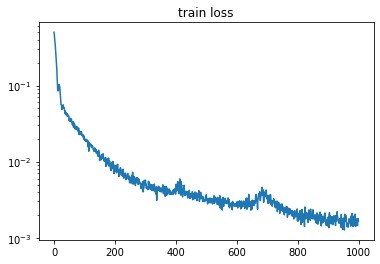

In [25]:
losses=train(model)

## Test dans la résolution de l'entrainement

In [28]:
def display_results(data_creator,model):

    nb=8
    fig,axs=plt.subplots(nb,4,sharex="all",figsize=(20,2*nb))
    X,Y=data_creator.make_XY(nb)
    Y_pred = model.call(X)
    f=X[:,:,0]*data_creator.normalisation_for_f
    alpha=X[:,:,1]

    res=data_creator.G2(X,Y)
    res_pred=data_creator.G2(X,Y_pred)
    for i in range(nb):
        axs[i,0].plot(f[i,:])
        axs[i,1].plot(alpha[i,:])
        axs[i,2].plot(Y[i,:,0],label="true")
        axs[i,2].plot(Y_pred[i,:,0],label="pred")
        axs[i,3].plot(res[i,:],label="true")
        axs[i,3].plot(res_pred[i,:],label="pred")

    axs[0,0].set_title("f")
    axs[0,1].set_title("alpha")
    axs[0,2].set_title("U")
    axs[0,3].set_title("residues")

    axs[0,2].legend()

    plt.show()


traçage de la fonction generate_XY
traçage de la méthode call de FNO1d_plus, pad=20


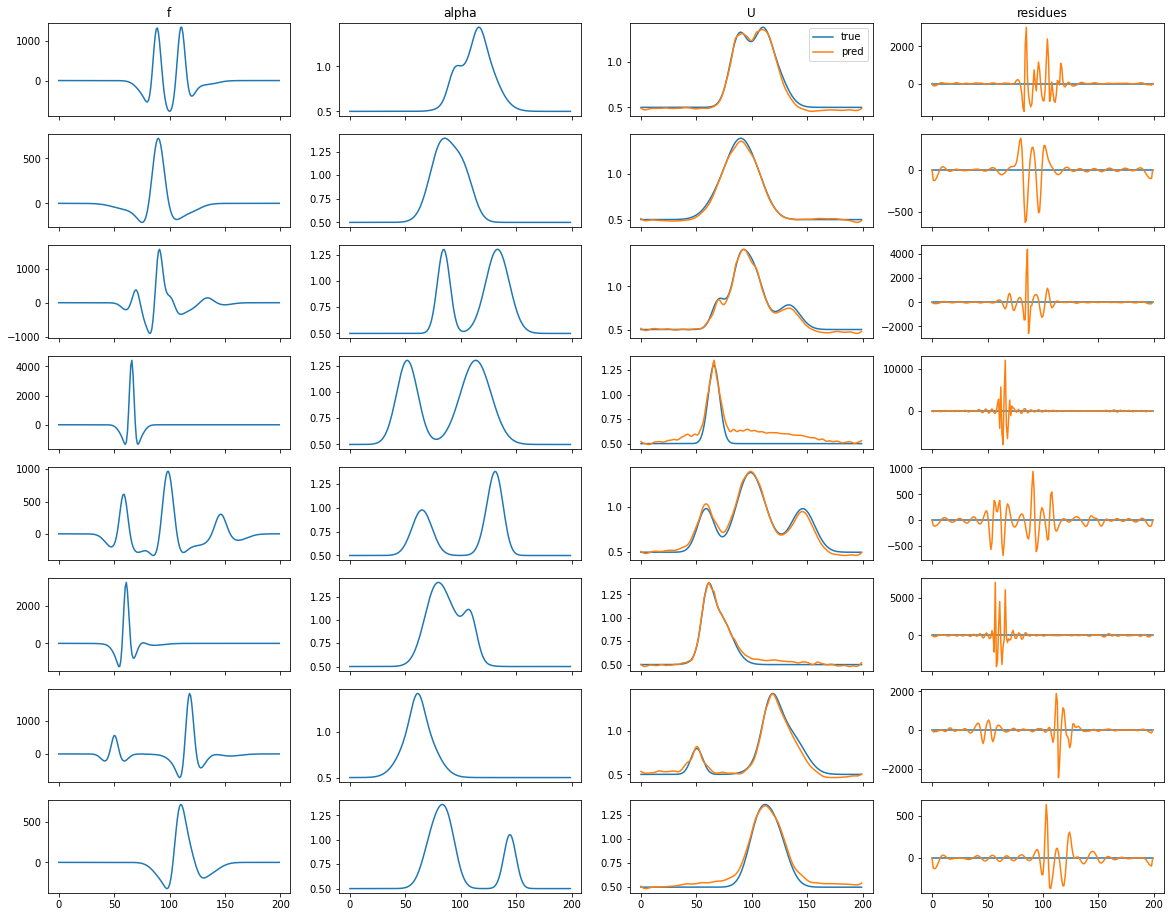

In [29]:
display_results(data_creator_train,model)

## Test avec résolution supèrieure

NewtonData with: nb points=300, kind of data:gauss
traçage de la fonction generate_XY
traçage de la méthode call de FNO1d_plus, pad=30


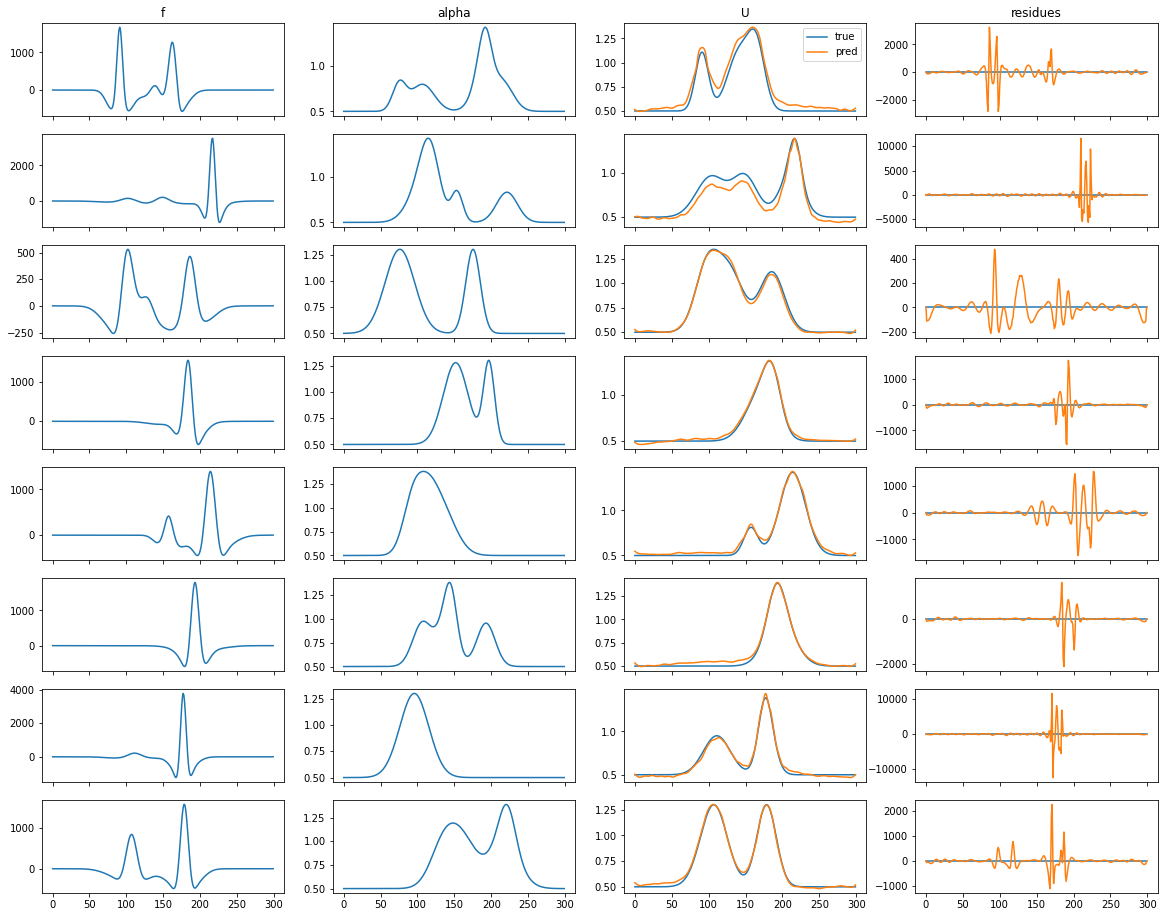

In [30]:
data_creator_test=give_me_newtonData(300)
display_results(data_creator_test,model)

## Test avec résolution inférieure

NewtonData with: nb points=100, kind of data:gauss
traçage de la fonction generate_XY
traçage de la méthode call de FNO1d_plus, pad=10


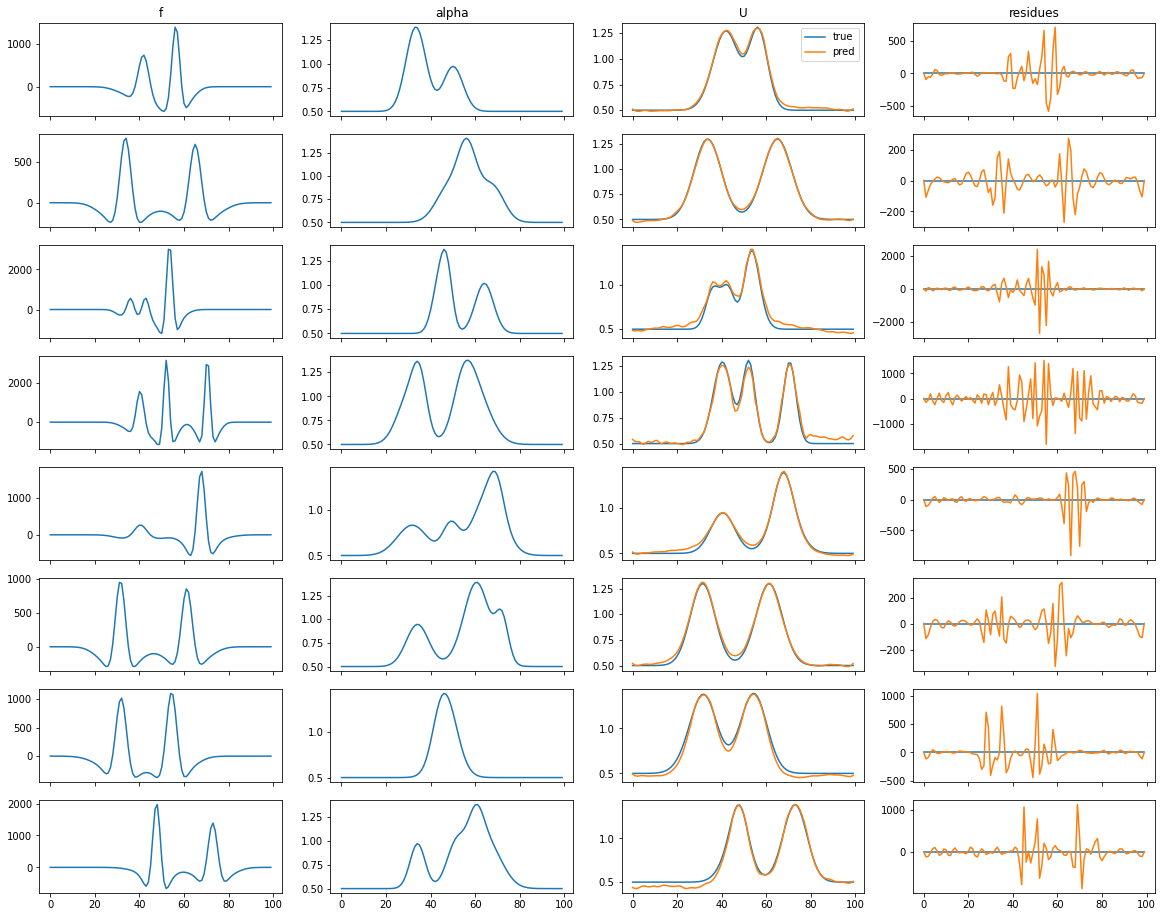

In [31]:
data_creator_test=data_creator_train=give_me_newtonData(100)
display_results(data_creator_test,model)

# Apprentissage multiple avec `grid_up`

Nous allons faire varier un à un les paramètres du FNO et tester sur différentes résolution, en utilisant `grid_up`


Sur des données périodiques, le padding est inutile. On le vérifiera en faisant varier `pad_prop`

Mais du coup on ne testera pas les différents `pad_kind` 


In [ ]:
def make_testor():
    resolutions_train=[100,150]
    resolutions_test=[50,75,100,125,150,175,200]

    creator_train={nx:give_me_newtonData(nx) for nx in resolutions_train}
    creator_test= {nx:give_me_newtonData(nx) for nx in resolutions_test}

    fixed_params = {
        "first_channel_unchanged": False,
        "pad_prop": 0.1,
        "freq_mix_size": 5,
        "pad_kind": "smooth_padding",
        "modes" : 20,
        "width" : 15,
        "nb_layer":4,
        "out_channels":1 #ne varie pas
    }

    pad_kinds=[
        'no_padding',
        #'zero_padding',
        'dirichlet_padding', 
        'neumann_padding', 
        'smooth_padding', 
        #'periodic_padding', 
        'smooth_periodizing_padding', 
        'linear_periodizing_padding']
    
    varying_params= {
        "first_channel_unchanged": [True,False],
        "pad_prop": [0,0.02,0.05,0.1,0.2],
        "freq_mix_size": [0,5,9],
        "pad_kind": pad_kinds,
        "modes" : [5,10,15,20],
        "width" : [5,10,15,20,30],
        "nb_layer":[2,3,4,5]
    }

    testor=gr.GridUp(
        fno.FNO1d_plus,
        creator_train,
        creator_test,
        fixed_params=fixed_params,
        varying_params=varying_params,
        minutes=1,
        verbose=False
    )
    return testor

testor=make_testor()

NewtonData with: nb points=100, kind of data:gauss
NewtonData with: nb points=150, kind of data:gauss
NewtonData with: nb points=50, kind of data:gauss
NewtonData with: nb points=75, kind of data:gauss
NewtonData with: nb points=100, kind of data:gauss
NewtonData with: nb points=125, kind of data:gauss
NewtonData with: nb points=150, kind of data:gauss
NewtonData with: nb points=175, kind of data:gauss
NewtonData with: nb points=200, kind of data:gauss
traçage de la fonction generate_XY


In [ ]:
testor.watch_param("first_channel_unchanged");

Look for model.first_channel_unchanged=[True, False]. Train with data-cases:[100, 150], Test with data-cases:[50, 75, 100, 125, 150, 175, 200]
Other parameters are: [('pad_prop', 0.1), ('freq_mix_size', 5), ('pad_kind', 'smooth_padding'), ('modes', 20), ('width', 15), ('nb_layer', 4), ('out_channels', 1)]
traçage de la fonction generate_XY


traçage de la fonction generate_XY
traçage de la fonction generate_XY
traçage de la fonction generate_XY
traçage de la fonction generate_XY
traçage de la fonction generate_XY
traçage de la fonction generate_XY
traçage de la fonction generate_XY
traçage de la fonction generate_XY


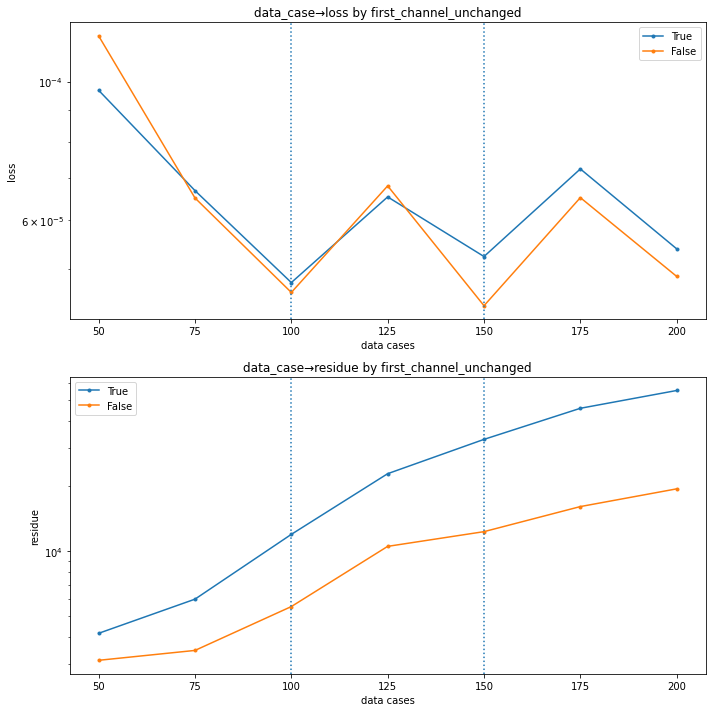

In [ ]:
testor.plot_last_result();

traçage de la fonction generate_XY
traçage de la fonction generate_XY
traçage de la fonction generate_XY
traçage de la fonction generate_XY
traçage de la fonction generate_XY
traçage de la fonction generate_XY
traçage de la fonction generate_XY


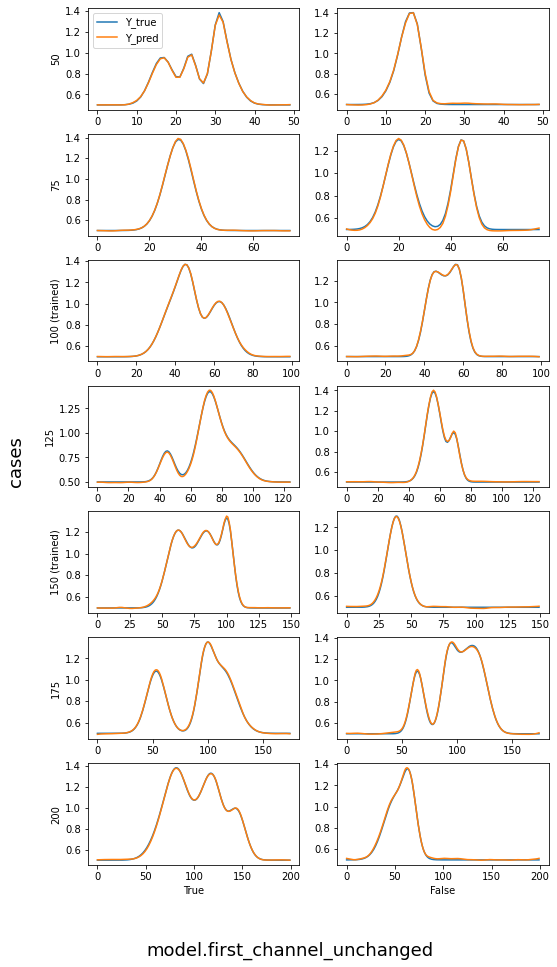

In [ ]:
testor.plot_prediction();

In [ ]:
testor.watch_param("pad_prop");

Look for model.pad_prop=[0, 0.02, 0.05, 0.1, 0.2]. Train with data-cases:[100, 150], Test with data-cases:[50, 75, 100, 125, 150, 175, 200]
Other parameters are: [('first_channel_unchanged', False), ('freq_mix_size', 5), ('pad_kind', 'smooth_padding'), ('modes', 20), ('width', 15), ('nb_layer', 4), ('out_channels', 1)]


TypeError: ignored

In [ ]:
testor.plot_last_result();

In [ ]:
testor.plot_prediction();

In [ ]:
testor.watch_param("freq_mix_size");

In [ ]:
testor.plot_last_result();

In [ ]:
testor.plot_prediction();

In [ ]:
testor.watch_param("modes");

In [ ]:
testor.plot_last_result();

In [ ]:
testor.plot_prediction();

In [ ]:
testor.watch_param("width");

In [ ]:
testor.plot_last_result();

In [ ]:
testor.plot_prediction();

In [ ]:
testor.watch_param("nb_layer");

In [ ]:
testor.plot_last_result();

In [ ]:
testor.plot_prediction();